<a href="https://colab.research.google.com/github/Asif-ibrahim101/100DaysofPython/blob/main/Ai_facial_recognitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports
import os, zipfile, cv2, numpy as np, matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    ConfusionMatrixDisplay
)

# Create folders for organization
os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

In [4]:
# Upload zips via Colab file picker
from google.colab import files
uploaded = files.upload()  # Choose your JAFFE-[70,30].zip and CK_dataset.zip (or your filenames)

# Change these to the exact uploaded filenames if different
jaffe_zip = [f for f in uploaded if "JAFFE" in f or "jaffe" in f][0]
ck_zip    = [f for f in uploaded if "CK" in f or "ck" in f][0]

# Unzip to data folders
with zipfile.ZipFile(jaffe_zip) as z:
    z.extractall("data/JAFFE")

with zipfile.ZipFile(ck_zip) as z:
    z.extractall("data/CK")

# Sanity check: list top-level folders
print("JAFFE folders:", os.listdir("data/JAFFE")[:10])
print("CK folders   :", os.listdir("data/CK")[:10])

Saving CK_dataset.zip to CK_dataset (2).zip
Saving JAFFE-[70,30] (1).zip to JAFFE-[70,30] (1) (2).zip
JAFFE folders: ['JAFFE-[70,30]']
CK folders   : ['CK_dataset']


In [6]:
def load_dataset_features(base_dir: str, feature_type: str = "HOG"):
    """
    Walk a dataset folder that has structure like:
      base_dir/
        Angry/
          img1.jpg ...
        Happy/
          img2.jpg ...
    Returns:
      X  : np.ndarray of feature vectors
      y  : np.ndarray of string labels
      imgs48 : list of 48x48 grayscale images (for later plotting)
      paths  : list of image paths (debug/reference)
    """
    X, y, imgs48, paths = [], [], [], []
    valid_ext = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

    for root, _, files in os.walk(base_dir):
        # Determine label from folder name (last part of the path)
        label = os.path.basename(root)
        # Skip base dir itself if it directly contains files with no label
        if label == os.path.basename(base_dir):
            pass
        for f in files:
            if not f.lower().endswith(valid_ext):
                continue
            p = os.path.join(root, f)
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is None:
                # unreadable/corrupt — skip
                continue
            img = cv2.resize(img, (48, 48))

            if feature_type.upper() == "HOG":
                feat, _ = hog(
                    img,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True
                )
            elif feature_type.upper() == "LBP":
                # Simple LBP example (P=8, R=1); you can try multi-scale later
                lbp = local_binary_pattern(img, P=8, R=1, method='default')
                feat = lbp.flatten()
            else:
                raise ValueError("feature_type must be 'HOG' or 'LBP'.")

            X.append(feat)
            y.append(label)
            imgs48.append(img)
            paths.append(p)

    X = np.array(X)
    y = np.array(y)
    return X, y, imgs48, paths

In [7]:
def run_experiment(dataset_dir: str, feature_type: str = "HOG", dataset_name: str = "DATASET"):
    """
    Full pipeline for a given dataset:
      - Load + feature extraction (HOG or LBP)
      - Label encode + stratified split
      - Tune SVM (RBF) and KNN
      - Evaluate on test set
      - Save confusion matrices and 3 prediction figure
      - Return metrics dict
    """
    # 1) Load features
    X, y, images48, paths = load_dataset_features(dataset_dir, feature_type=feature_type)
    print(f"[{dataset_name}] Loaded:", X.shape, "Classes:", sorted(set(y)))

    # 2) Encode labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    # 3) Stratified split
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y_enc, np.arange(len(y_enc)),
        test_size=0.2, random_state=42, stratify=y_enc
    )

    # 4) Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 5) SVM pipeline + grid
    svm_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("svm", SVC(kernel="rbf", class_weight="balanced"))
    ])
    svm_grid = {
        "svm__C": [0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.001]
    }
    svm_gs = GridSearchCV(svm_pipe, svm_grid, cv=cv, n_jobs=-1, scoring="f1_macro")
    svm_gs.fit(X_train, y_train)
    svm_best = svm_gs.best_estimator_
    print(f"[{dataset_name}] Best SVM:", svm_gs.best_params_, "CV f1_macro:", round(svm_gs.best_score_, 3))

    # 6) KNN pipeline + grid (comparator)
    knn_pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("knn", KNeighborsClassifier())
    ])
    knn_grid = {
        "knn__n_neighbors": [1, 3, 5, 7, 9],
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2]  # Manhattan vs Euclidean
    }
    knn_gs = GridSearchCV(knn_pipe, knn_grid, cv=cv, n_jobs=-1, scoring="f1_macro")
    knn_gs.fit(X_train, y_train)
    knn_best = knn_gs.best_estimator_
    print(f"[{dataset_name}] Best KNN:", knn_gs.best_params_, "CV f1_macro:", round(knn_gs.best_score_, 3))

    # 7) Evaluate both on test set
    y_pred_svm = svm_best.predict(X_test)
    y_pred_knn = knn_best.predict(X_test)

    svm_acc = accuracy_score(y_test, y_pred_svm)
    svm_f1  = f1_score(y_test, y_pred_svm, average='macro')
    knn_acc = accuracy_score(y_test, y_pred_knn)
    knn_f1  = f1_score(y_test, y_pred_knn, average='macro')

    print(f"[{dataset_name}] SVM  acc={svm_acc:.3f}  f1_macro={svm_f1:.3f}")
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
    print(f"[{dataset_name}] KNN  acc={knn_acc:.3f}  f1_macro={knn_f1:.3f}")

    # 8) Confusion matrices (save)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_svm, display_labels=le.classes_, xticks_rotation=45
    )
    plt.tight_layout()
    plt.savefig(f"figures/confmat_svm_{dataset_name}.png", dpi=200)
    plt.show()

    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_knn, display_labels=le.classes_, xticks_rotation=45
    )
    plt.tight_layout()
    plt.savefig(f"figures/confmat_knn_{dataset_name}.png", dpi=200)
    plt.show()

    # 9) Figure: 3 example classified faces using SVM (required by brief)
    rng = np.random.default_rng(42)
    choice = rng.choice(len(y_test), size=min(3, len(y_test)), replace=False)

    plt.figure(figsize=(8, 3))
    for i, idx in enumerate(choice, 1):
        img = images48[idx_test[idx]]
        true_lab = le.classes_[y_test[idx]]
        pred_lab = le.classes_[y_pred_svm[idx]]
        plt.subplot(1, len(choice), i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"T:{true_lab}\nP:{pred_lab}")
    plt.tight_layout()
    plt.savefig(f"figures/example_preds_{dataset_name}.png", dpi=200)
    plt.show()

    # 10) Return everything useful for later comparison and reporting
    metrics = {
        "dataset": dataset_name,
        "labels": list(le.classes_),
        "svm": {"acc": float(svm_acc), "f1_macro": float(svm_f1), "best_params": svm_gs.best_params_},
        "knn": {"acc": float(knn_acc), "f1_macro": float(knn_f1), "best_params": knn_gs.best_params_},
    }
    return metrics

[JAFFE] Loaded: (183, 900) Classes: [np.str_('Angry'), np.str_('Fear'), np.str_('Happy'), np.str_('Neutral'), np.str_('Sad'), np.str_('Surprise')]
[JAFFE] Best SVM: {'svm__C': 10, 'svm__gamma': 'scale'} CV f1_macro: 0.623
[JAFFE] Best KNN: {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'} CV f1_macro: 0.647
[JAFFE] SVM  acc=0.811  f1_macro=0.810
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00         6
        Fear       0.71      0.71      0.71         7
       Happy       0.86      1.00      0.92         6
     Neutral       0.71      0.83      0.77         6
         Sad       0.60      0.50      0.55         6
    Surprise       1.00      0.83      0.91         6

    accuracy                           0.81        37
   macro avg       0.81      0.81      0.81        37
weighted avg       0.81      0.81      0.81        37

[JAFFE] KNN  acc=0.838  f1_macro=0.838


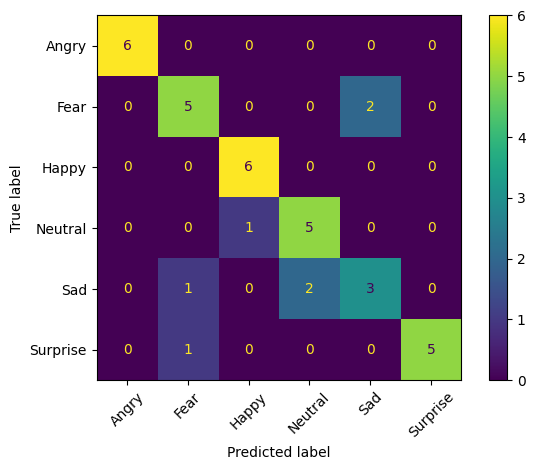

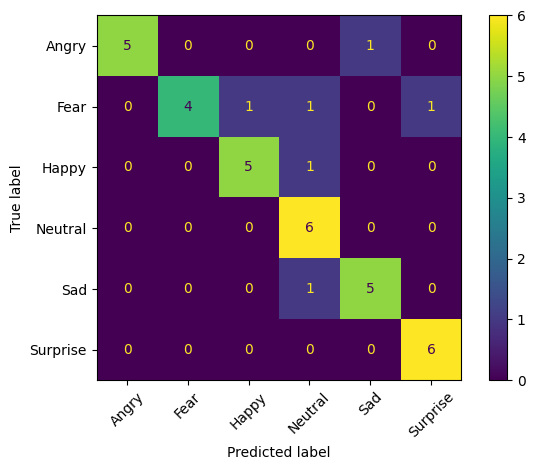

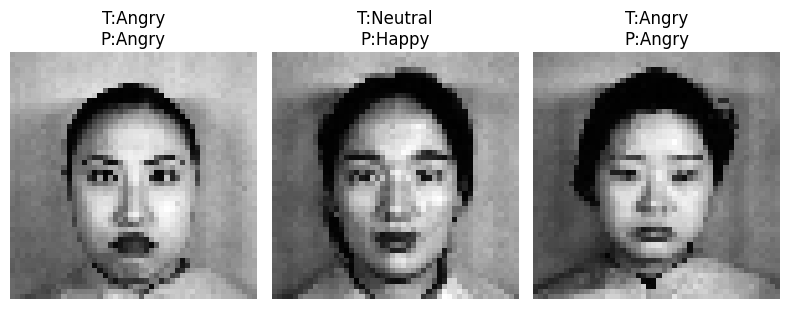

{'dataset': 'JAFFE',
 'labels': [np.str_('Angry'),
  np.str_('Fear'),
  np.str_('Happy'),
  np.str_('Neutral'),
  np.str_('Sad'),
  np.str_('Surprise')],
 'svm': {'acc': 0.8108108108108109,
  'f1_macro': 0.8101898101898102,
  'best_params': {'svm__C': 10, 'svm__gamma': 'scale'}},
 'knn': {'acc': 0.8378378378378378,
  'f1_macro': 0.8376845376845377,
  'best_params': {'knn__n_neighbors': 1,
   'knn__p': 1,
   'knn__weights': 'uniform'}}}

In [8]:
jaffe_metrics = run_experiment("data/JAFFE", feature_type="HOG", dataset_name="JAFFE")
jaffe_metrics

[CK] Loaded: (484, 900) Classes: [np.str_('anger'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sadness'), np.str_('surprise')]
[CK] Best SVM: {'svm__C': 1, 'svm__gamma': 'scale'} CV f1_macro: 0.512
[CK] Best KNN: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'} CV f1_macro: 0.376
[CK] SVM  acc=0.526  f1_macro=0.427
              precision    recall  f1-score   support

       anger       0.31      0.33      0.32        12
        fear       0.00      0.00      0.00         4
       happy       0.90      0.86      0.88        21
     neutral       0.43      0.42      0.43        24
     sadness       0.17      0.17      0.17        12
    surprise       0.85      0.71      0.77        24

    accuracy                           0.53        97
   macro avg       0.44      0.41      0.43        97
weighted avg       0.57      0.53      0.55        97

[CK] KNN  acc=0.546  f1_macro=0.364


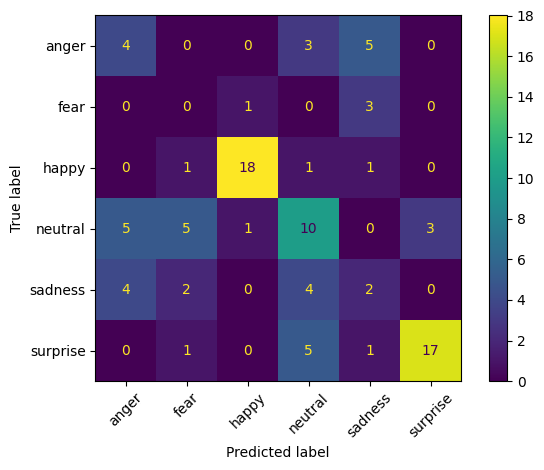

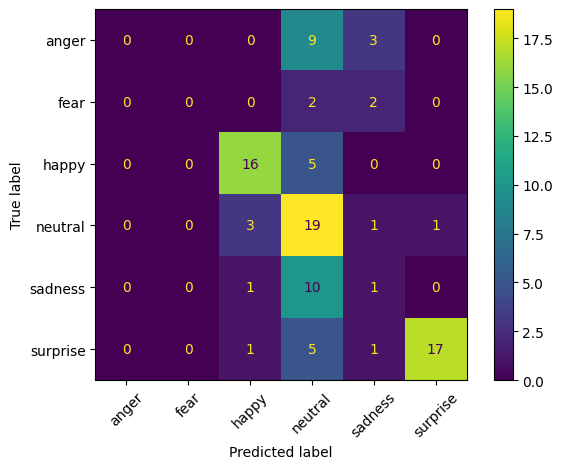

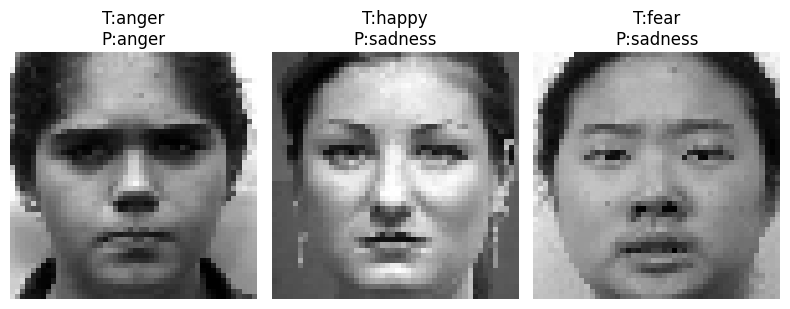

{'dataset': 'CK',
 'labels': [np.str_('anger'),
  np.str_('fear'),
  np.str_('happy'),
  np.str_('neutral'),
  np.str_('sadness'),
  np.str_('surprise')],
 'svm': {'acc': 0.5257731958762887,
  'f1_macro': 0.42716243912922686,
  'best_params': {'svm__C': 1, 'svm__gamma': 'scale'}},
 'knn': {'acc': 0.5463917525773195,
  'f1_macro': 0.3641570141570141,
  'best_params': {'knn__n_neighbors': 9,
   'knn__p': 1,
   'knn__weights': 'distance'}}}

In [9]:
ck_metrics = run_experiment("data/CK", feature_type="HOG", dataset_name="CK")
ck_metrics

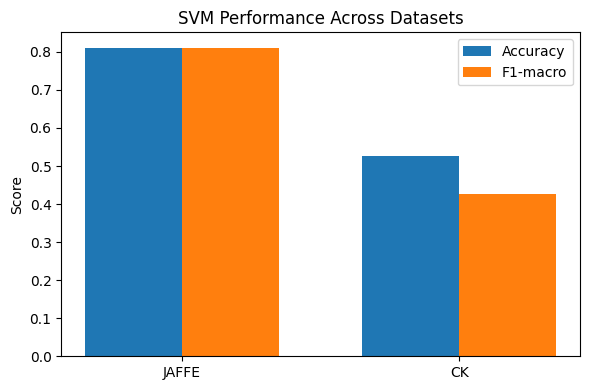

{'JAFFE': {'acc': 0.811, 'f1': 0.81}, 'CK': {'acc': 0.526, 'f1': 0.427}}


In [10]:
# Build a small comparison bar chart from returned metrics
datasets = ["JAFFE", "CK"]
accs = [jaffe_metrics["svm"]["acc"], ck_metrics["svm"]["acc"]]
f1s  = [jaffe_metrics["svm"]["f1_macro"], ck_metrics["svm"]["f1_macro"]]

plt.figure(figsize=(6,4))
x = np.arange(len(datasets))
w = 0.35
plt.bar(x - w/2, accs, width=w, label="Accuracy")
plt.bar(x + w/2, f1s,  width=w, label="F1-macro")
plt.xticks(x, datasets)
plt.ylabel("Score")
plt.title("SVM Performance Across Datasets")
plt.legend()
plt.tight_layout()
plt.savefig("figures/JAFFE_vs_CK_SVM.png", dpi=200)
plt.show()

print({
    "JAFFE": {"acc": round(accs[0],3), "f1": round(f1s[0],3)},
    "CK"   : {"acc": round(accs[1],3), "f1": round(f1s[1],3)}
})

In [11]:
import csv

rows = [
    ["Dataset","Model","Accuracy","F1_macro","Best_Params"],
    ["JAFFE","SVM", jaffe_metrics["svm"]["acc"], jaffe_metrics["svm"]["f1_macro"], str(jaffe_metrics["svm"]["best_params"])],
    ["JAFFE","KNN", jaffe_metrics["knn"]["acc"], jaffe_metrics["knn"]["f1_macro"], str(jaffe_metrics["knn"]["best_params"])],
    ["CK","SVM", ck_metrics["svm"]["acc"], ck_metrics["svm"]["f1_macro"], str(ck_metrics["svm"]["best_params"])],
    ["CK","KNN", ck_metrics["knn"]["acc"], ck_metrics["knn"]["f1_macro"], str(ck_metrics["knn"]["best_params"])],
]

with open("results/summary.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("Saved: results/summary.csv")

Saved: results/summary.csv
